# Contents

* [Processing the data](#1)
    - [Load and process data](#1.1)
    - [Define functions](#1.2)
* [CNN sequential model](#2)
    - [Evaluation](#2.1)
      - [Visualize Data](#2.1.1)
    - [Data Augmentation](#2.2)
    - [Regularization](#2.3)
    - [Increased Epochs](#2.4)
    - [Padding](#2.5)
    - [Bigger Network](#2.6)
    - [More Data](#2.7)
    - [Bigger Image](#2.8)

In [2]:
# Import libraries we will use
import numpy as np
import pandas as pd
import seaborn as sn
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import shutil

<a id="1"></a>
# Processing the data
There are 43 classes, with the training images grouped into 43 folders in the Train directory. 


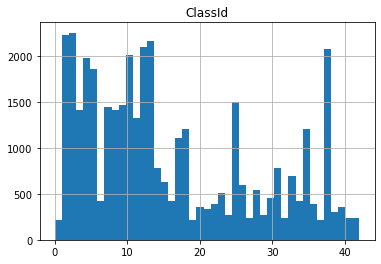

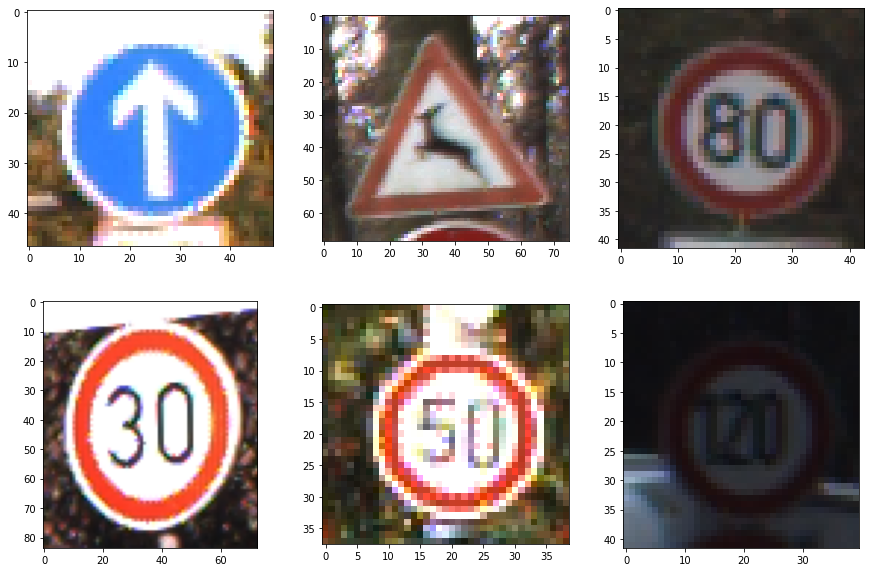

In [5]:
#Assign image and file locations

trainIMG_path = work_dir+'Train/'
testIMG_path =  work_dir+'Test/'
trainFile_path = work_dir+'Train.csv'
testFile_path = work_dir+'Test.csv'

#Read tables

train_data = pd.read_csv(trainFile_path)
test_data = pd.read_csv(testFile_path)

# Check data distribution

train_data.hist(column='ClassId',bins=43)

# Visualise some random images

trainImage_paths = train_data["Path"].values
indices = np.random.randint(len(trainImage_paths), size=6)
fig = plt.figure(figsize=(15,10))
pix = 1
for ix in indices:
    fig.add_subplot(2,3,pix)
    pix += 1
    random_img = plt.imread(work_dir+trainImage_paths[ix])
    plt.imshow(random_img)

The distribution shows that there is a big difference among class representations, some classes have very few examples, which might need some extra attention when contstructing the training/dev set splits.

Looking at the images and image dimension, we can also find out that the image heights/widths vary between 25 to 243 pixels, which is due to having 30 images of the same table taken from slightly different ranges and angles - most probably extracted from camera images of a vehicle in motion.

<a id="1.1"></a>
## Load dataset, set up train/dev/test splits

Keras can gather all images and generate labels from the directory names, and shuffles the data by default.
Since we don't want to give significance to label values, it is better to use one-hot encoding.
All images must have the same dimensions for the pipeline we are going to use. The best choice is to downscale to the size of the smallest image, 
but we also want to take preferance for square matrices. The best interpolation technique for downscaling is found to be "lanczos".

In [6]:
image_dim = 30

train_set = tf.keras.utils.image_dataset_from_directory(trainIMG_path, label_mode='categorical', validation_split=0.2,
                                                        subset='training', seed=42, image_size=(image_dim,image_dim), interpolation='lanczos3')
dev_set = tf.keras.utils.image_dataset_from_directory(trainIMG_path, label_mode='categorical', validation_split=0.2,
                                                      subset='validation', seed=42, image_size=(image_dim,image_dim), interpolation='lanczos3')

# test images are not categorised into folders by default,
# and we need to have specific folder structure for our tensorflow pipeline.
if not os.path.isdir(work_dir+'TestCat'):
    os.makedirs(work_dir+'TestCat')
    for i in range(43):
        os.makedirs(work_dir+'TestCat/'+str(i))

    for ix, row in test_data.iterrows():
        shutil.copy2(work_dir+row['Path'], work_dir+'TestCat/'+str(row['ClassId']))
    
test_set = tf.keras.utils.image_dataset_from_directory(work_dir+'TestCat/', label_mode='categorical',
                                                       image_size=(image_dim,image_dim), interpolation='lanczos3')


# improves computation performance, but makes fetching data from dataset objects more complicated
#AUTOTUNE = tf.data.AUTOTUNE
#train_set = train_set.cache().prefetch(buffer_size=AUTOTUNE)
#dev_set = dev_set.cache().prefetch(buffer_size=AUTOTUNE)
#test_set = test_set.cache().prefetch(buffer_size=AUTOTUNE)

Found 39209 files belonging to 43 classes.
Using 31368 files for training.
Found 39209 files belonging to 43 classes.
Using 7841 files for validation.
Found 12630 files belonging to 43 classes.


<a id="1.2"></a>
## Define some useful functions

In [7]:
def get_conf(model,dataset):
    """
    Computes the confusion matrix between the ground thruth labels and the predicted labels.
    
    Arguments:
    model - Tensorflow model
    dataset - Tensorflow dataset, containing the image data and labels
    
    Returns:
    tensorflow confusion matrix as a numpy array
    """
    predictions = np.array([])
    labels =  np.array([])
    for x, y in dataset:
        predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis = -1)])
        labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

    return tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()

def extract_labels(dataset):
    """
    Extracts the labels from a tensorflow dataset
    
    Arguments:
    dataset - Tensorflow dataset
    
    Returns:
    labels - list of labels
    """
    labels = []
    for x,y in dataset:
        labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])
        
    return labels

def get_FNR(conf):
    """
    Collects the false negatives, and computes the false negative rate
    
    Arguments:
    conf - tf confusion matrix
    
    Returns:
    wrong_predictions - list of false negatives per label
    mislabel_ratio - list of FNR per label
    
    """
    wrong_predictions = np.zeros(43) #false negatives
    mislabel_ratio = np.zeros(43) # the false negative rate
    for i in range(43):
        wrong_predictions[i] = np.sum(conf[:,i]) - conf[i,i]
        mislabel_ratio[i] = wrong_predictions[i] / conf[i,i]
        
    return wrong_predictions, mislabel_ratio

<a id="2"></a>
# CNN sequential model

We begin with a simple 3 conv. layer sequential model, using 32 pcs of 3x3 kernels with stride of 1 - a standard parameter choice for image processing tasks. We add a default max pooling layer after each convolution (2x2, no stride, no padding) for dimensionality reduction and a regularization effect.
We will use ReLu activations for the hidden layers and a single dense layer with softmax for the output. We will use the adam optimizer, which combines the advantages of RMSProp and Adagrad.

In [8]:
seq_model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255), # In case of image processing, its general practice to just standardize via division by 255
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(43, activation='softmax')
])

seq_model.compile(optimizer='Adam', loss=tf.losses.CategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
history = seq_model.fit(train_set,validation_data=dev_set,epochs=10)

loss, acc = seq_model.evaluate(test_set)

Epoch 1/10
981/981 [==============================] - 17s 16ms/step - loss: 1.9202 - accuracy: 0.4589 - val_loss: 0.7770 - val_accuracy: 0.7748
Epoch 2/10
981/981 [==============================] - 16s 17ms/step - loss: 0.5072 - accuracy: 0.8551 - val_loss: 0.3315 - val_accuracy: 0.9103
Epoch 3/10
981/981 [==============================] - 16s 17ms/step - loss: 0.2567 - accuracy: 0.9270 - val_loss: 0.2307 - val_accuracy: 0.9379
Epoch 4/10
981/981 [==============================] - 16s 17ms/step - loss: 0.1611 - accuracy: 0.9557 - val_loss: 0.1849 - val_accuracy: 0.9486
Epoch 5/10
981/981 [==============================] - 16s 17ms/step - loss: 0.1176 - accuracy: 0.9679 - val_loss: 0.1382 - val_accuracy: 0.9653
Epoch 6/10
981/981 [==============================] - 17s 17ms/step - loss: 0.0877 - accuracy: 0.9754 - val_loss: 0.1201 - val_accuracy: 0.9694
Epoch 7/10
981/981 [==============================] - 16s 17ms/step - loss: 0.0670 - accuracy: 0.9802 - val_loss: 0.1124 - val_accuracy:

<a id="2.1"></a>
## Evaluate

The results can slightly differ, depending on how tf shuffles the data, but we can achieve around 0.99 accuracy on the training set and around 0.98 on the dev set. We can define our Bayes error to be the expert human error rate, which we can assume to be zero - or the accuracy of 1. We can then see that there is no big difference between the training error and the bayes error, so we do not seem to have issue with bias in this initial model. We also have a small difference between the training and the devset accuracy, so we seem to have low variance.
However, the test set accuracy is aprx. 0.91, which suggests overfitting.

<a id="2.1.1"></a>
### Visualize Data

We can compute and visualize the confusion matrix and the false negative rate to get an idea about which classes are getting mislabeled and at what rate. A red line is added at the mean FNR, so its easier to see which classes are doing extremely poor.

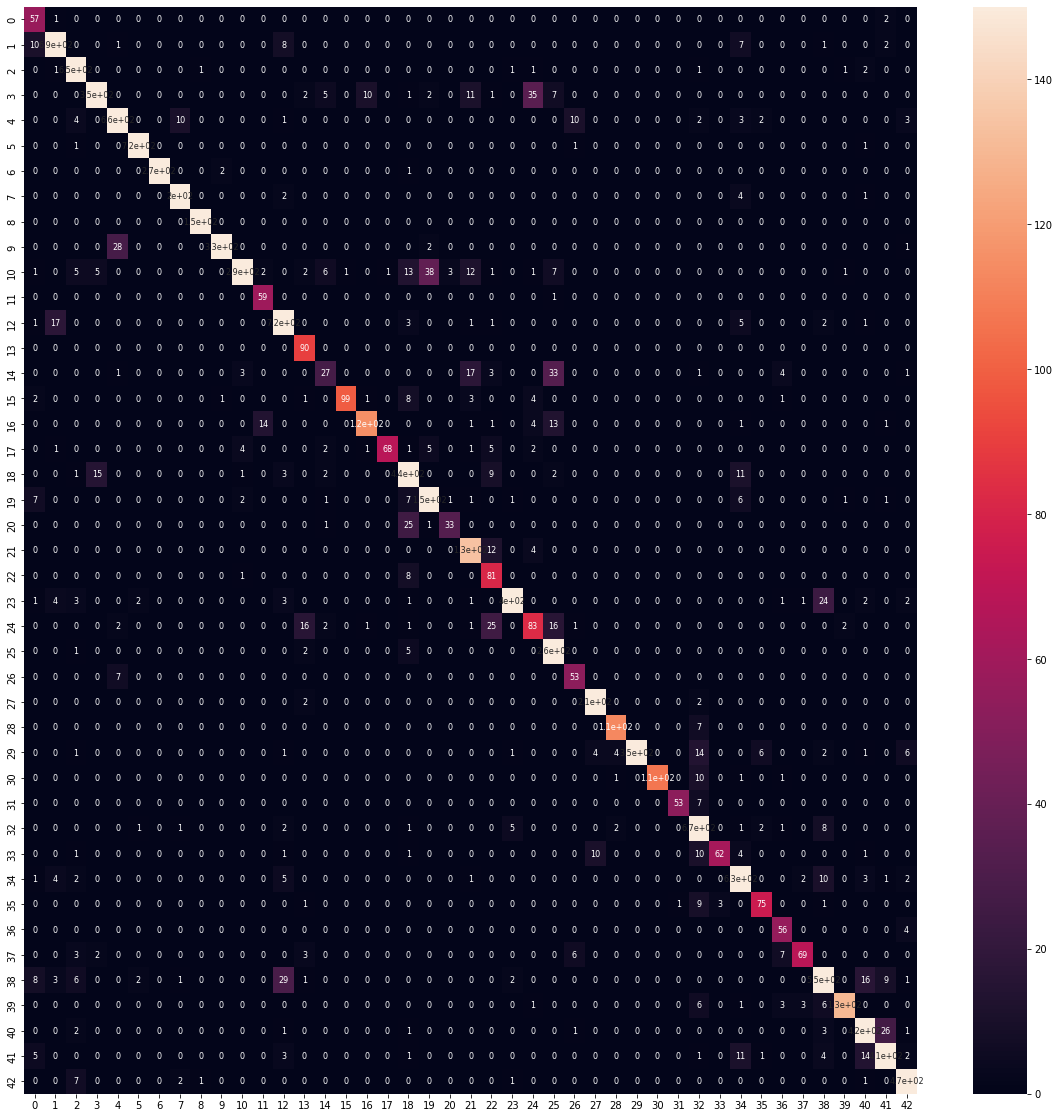

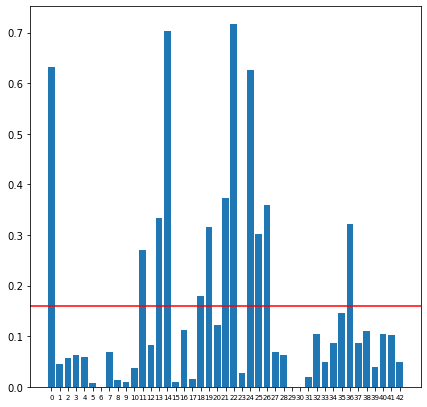

In [9]:
conf = get_conf(model=seq_model,dataset=test_set)
plt.figure(figsize=(20,20))
sn.heatmap(conf, annot=True, vmax=150, annot_kws={'size':8})

fn, fnr = get_FNR(conf)

plt.figure(figsize=(7, 7))
plt.bar(range(43),fnr)
plt.axhline(y=np.mean(fnr), color='r', linestyle='-')
_ = plt.xticks(range(43), fontsize=7)

The heatmap and the FNR discovers which classes our models are confusing the most. Firstly, we are interested in classes with the worst rates, and that have 'warm' cells in the heatmap. Although different shuffles tend to mix up the FNR results, some classes - e.g. 20 - always seem to perform poorly. If we compare the images in the test and training set - apart from having relatively few training examples for this class - we can notice that the test images are brighter in general, than our training images.

We should then also compare the distribution of the training, dev and test sets.

Text(0.5, 1.0, 'Test')

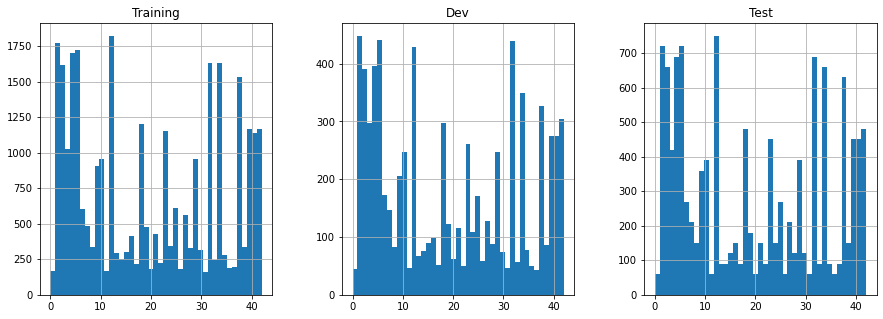

In [10]:
train_labels = extract_labels(train_set)
dev_labels = extract_labels(dev_set)
test_labels = extract_labels(test_set)


fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(15,5))
pd.DataFrame(train_labels).hist(ax=axes[0],bins=43)
pd.DataFrame(dev_labels).hist(ax=axes[1],bins=43)
pd.DataFrame(test_labels).hist(ax=axes[2],bins=43)
axes[0].set_title('Training')
axes[1].set_title('Dev')
axes[2].set_title('Test')

Since the distribution of the training, dev and test data look similar, the variance is unlikely to come from a data mismatch issue.

Finally let's visualise the learning curves:

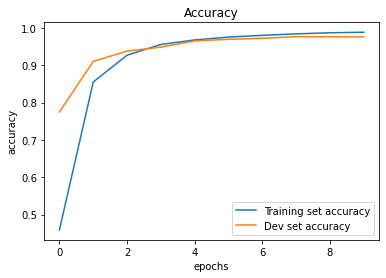

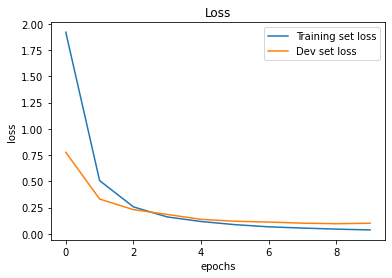

In [11]:
plt.figure(0)
plt.plot(history.history['accuracy'], label='Training set accuracy')
plt.plot(history.history['val_accuracy'], label='Dev set accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure(1)
plt.plot(history.history['loss'], label='Training set loss')
plt.plot(history.history['val_loss'], label='Dev set loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

The learning curves look ordinary,the optimiser seems to be close to convergence at 10 epochs. Stopping early does not seem a viable step here, however, there could be a small gain in training longer, as the losses seem to be in a slight descent.

<a id="2.2"></a>
## Data Augmentation

First, we will try to improve the available dataset by introducing some directed noise. We looked at training and test images from "bad" classes, we can identify that the test set slightly differs from our training set in brightness, rotation and maybe the size of tables in the images. We will try to introduce some diversity by randomising these features, hoping our model will generalise better to new examples.

In [12]:
seq_model_aug = tf.keras.Sequential([
  tf.keras.layers.RandomContrast(factor=0.1), #vary the light condition of the images
  tf.keras.layers.RandomZoom(height_factor=0.1), #get different table sizes
  #tf.keras.layers.RandomRotation(0.05), #get small rotations (slightly reduces accuracy)
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(43, activation='softmax')
])

seq_model_aug.compile(optimizer='Adam', loss=tf.losses.CategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
history = seq_model_aug.fit(train_set,validation_data=dev_set,epochs=10)

loss, acc = seq_model_aug.evaluate(test_set)

Epoch 1/10
981/981 [==============================] - 18s 17ms/step - loss: 2.0767 - accuracy: 0.4270 - val_loss: 0.8715 - val_accuracy: 0.7591
Epoch 2/10
981/981 [==============================] - 19s 19ms/step - loss: 0.5916 - accuracy: 0.8348 - val_loss: 0.3689 - val_accuracy: 0.9042
Epoch 3/10
981/981 [==============================] - 17s 18ms/step - loss: 0.3168 - accuracy: 0.9143 - val_loss: 0.2657 - val_accuracy: 0.9285
Epoch 4/10
981/981 [==============================] - 17s 18ms/step - loss: 0.2113 - accuracy: 0.9430 - val_loss: 0.1910 - val_accuracy: 0.9536
Epoch 5/10
981/981 [==============================] - 17s 18ms/step - loss: 0.1549 - accuracy: 0.9566 - val_loss: 0.1495 - val_accuracy: 0.9624
Epoch 6/10
981/981 [==============================] - 17s 17ms/step - loss: 0.1222 - accuracy: 0.9654 - val_loss: 0.1306 - val_accuracy: 0.9685
Epoch 7/10
981/981 [==============================] - 17s 17ms/step - loss: 0.0974 - accuracy: 0.9724 - val_loss: 0.1147 - val_accuracy:

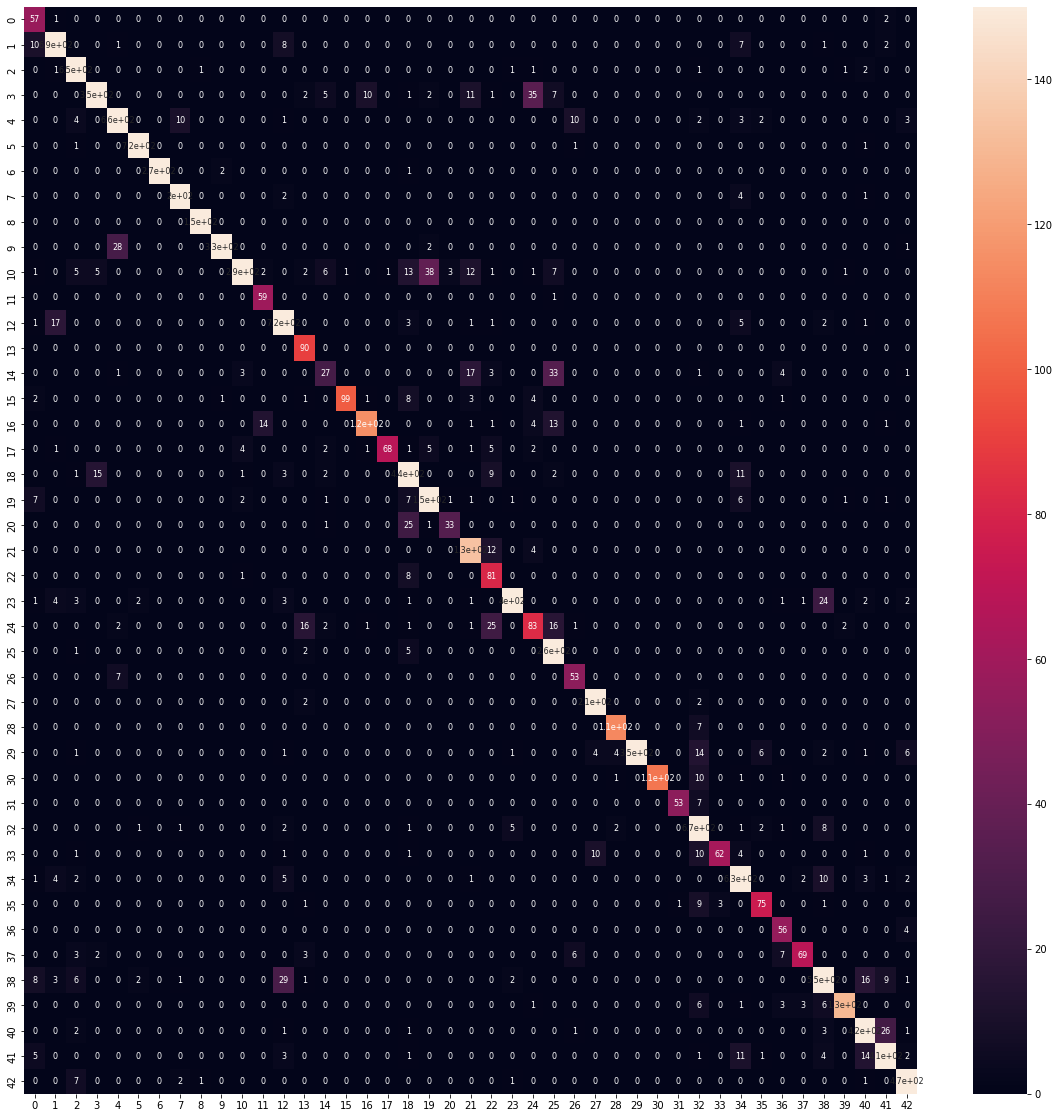

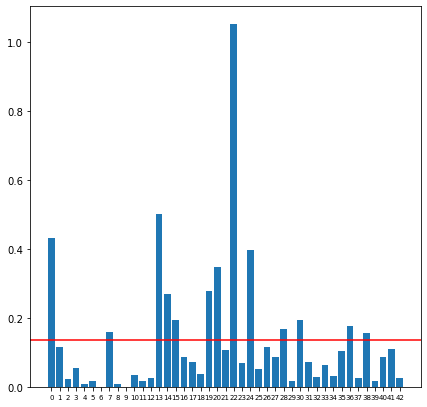

In [13]:
conf_aug = get_conf(model=seq_model_aug, dataset=test_set)
fn_aug, fnr_aug = get_FNR(conf_aug)

plt.figure(figsize=(20,20))
sn.heatmap(conf, annot=True, vmax=150, annot_kws={'size':8})

plt.figure(figsize=(7, 7))
plt.bar(range(43),fnr_aug)
plt.axhline(y=np.mean(fnr_aug), color='r', linestyle='-')
_ = plt.xticks(range(43), fontsize=7)

Augmenting the rotation actually made the accuracy on all sets slightly worse, so this feature is left out from the final/visualized experiment.

Introducing noise to contrast levels and to table sizes via zoom yields a slight improvement over the test and dev sets, and reduces the gap between the dev and test set via an improvement of ~1.5% on the test set accuracy. We can also notice that both the extremely high FNR values and the mean is now lower.

<a id="2.3"></a>
## Regularization

Our initial model only has a single dense layer, which is responsible for the prediction via the softmax activation. Usually dropout regularisation is only applied to fully connected layers, as proposed by the original research paper. However, more recent findings - such as [this](http://mipal.snu.ac.kr/images/1/16/Dropout_ACCV2016.pdf) analysis - show that there can be gains in applying low prob. dropout to convolutional layers.

Epoch 1/15
981/981 [==============================] - 19s 19ms/step - loss: 2.3928 - accuracy: 0.3286 - val_loss: 1.1243 - val_accuracy: 0.6801
Epoch 2/15
981/981 [==============================] - 19s 19ms/step - loss: 0.9854 - accuracy: 0.6940 - val_loss: 0.4959 - val_accuracy: 0.8661
Epoch 3/15
981/981 [==============================] - 19s 19ms/step - loss: 0.5741 - accuracy: 0.8256 - val_loss: 0.2731 - val_accuracy: 0.9285
Epoch 4/15
981/981 [==============================] - 18s 19ms/step - loss: 0.3997 - accuracy: 0.8782 - val_loss: 0.1744 - val_accuracy: 0.9570
Epoch 5/15
981/981 [==============================] - 19s 19ms/step - loss: 0.3013 - accuracy: 0.9090 - val_loss: 0.1450 - val_accuracy: 0.9610
Epoch 6/15
981/981 [==============================] - 19s 19ms/step - loss: 0.2454 - accuracy: 0.9252 - val_loss: 0.1137 - val_accuracy: 0.9698
Epoch 7/15
981/981 [==============================] - 19s 19ms/step - loss: 0.2072 - accuracy: 0.9370 - val_loss: 0.0792 - val_accuracy:

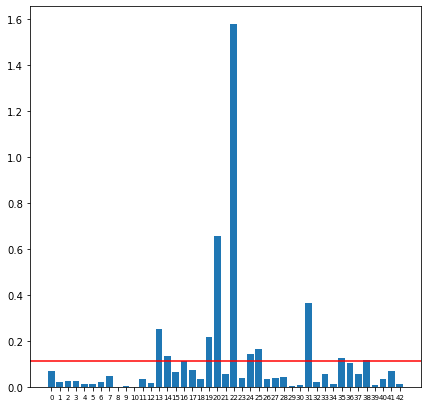

In [14]:
seq_model_aug_reg = tf.keras.Sequential([
  tf.keras.layers.RandomContrast(factor=0.1),
  tf.keras.layers.RandomZoom(height_factor=0.1),
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(rate=0.1),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(rate=0.1),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(rate=0.1),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(43, activation='softmax')
])

seq_model_aug_reg.compile(optimizer='Adam', loss=tf.losses.CategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
history = seq_model_aug_reg.fit(train_set,validation_data=dev_set,epochs=15) #best result with 15 epochs

loss, acc = seq_model_aug_reg.evaluate(test_set)

#plot results
conf_reg = get_conf(model=seq_model_aug_reg, dataset=test_set)
fn_reg, fnr_reg = get_FNR(conf_reg)

plt.figure(figsize=(7, 7))
plt.bar(range(43),fnr_reg)
plt.axhline(y=np.mean(fnr_reg), color='r', linestyle='-')
_ = plt.xticks(range(43), fontsize=7)

Introducing dropout at the convolutional layers decreased our training accuracy, but the model improved results on the test set, while the dev set seems to be unaffected. We also managed to get some minor improvements on the FNR plot. Now with Training Acc at 0.96, Dev set Acc at 0.98 and Test Accuracy at 0.94 we have some new things we can look at. Now we have a bigger gap between the Bayes Error and the Training error, so we can look into finding avoidable bias.

<a id="2.4"></a>
## Increased epochs

The simplest way is probably to try training our existing model longer. With 15 epochs, we increased accuracy over all data sets reaching 0.975/0.99/0.952 respectively. Training even longer did not affect the training and dev set accuracies significantly, and actually made test set accuracy slightly worse.

<a id="2.5"></a>
## Padding

With padding at the convolutional layers we decrease the dimension reduction effect, but we can keep information at the edges. 

In [15]:
seq_model_v2 = tf.keras.Sequential([
  tf.keras.layers.RandomContrast(factor=0.1),
  tf.keras.layers.RandomZoom(height_factor=0.1),
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(rate=0.1),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(rate=0.1),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(rate=0.1),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(43, activation='softmax')
])

seq_model_v2.compile(optimizer='Adam', loss=tf.losses.CategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
history = seq_model_v2.fit(train_set,validation_data=dev_set,epochs=15)

loss, acc = seq_model_v2.evaluate(test_set)

Epoch 1/15
981/981 [==============================] - 23s 23ms/step - loss: 2.0685 - accuracy: 0.4054 - val_loss: 0.8140 - val_accuracy: 0.7857
Epoch 2/15
981/981 [==============================] - 22s 22ms/step - loss: 0.6622 - accuracy: 0.7960 - val_loss: 0.2914 - val_accuracy: 0.9313
Epoch 3/15
981/981 [==============================] - 22s 22ms/step - loss: 0.3510 - accuracy: 0.8926 - val_loss: 0.1541 - val_accuracy: 0.9622
Epoch 4/15
981/981 [==============================] - 22s 22ms/step - loss: 0.2397 - accuracy: 0.9275 - val_loss: 0.1089 - val_accuracy: 0.9723
Epoch 5/15
981/981 [==============================] - 22s 22ms/step - loss: 0.1823 - accuracy: 0.9438 - val_loss: 0.0828 - val_accuracy: 0.9784
Epoch 6/15
981/981 [==============================] - 22s 22ms/step - loss: 0.1508 - accuracy: 0.9531 - val_loss: 0.0664 - val_accuracy: 0.9839
Epoch 7/15
981/981 [==============================] - 21s 22ms/step - loss: 0.1281 - accuracy: 0.9601 - val_loss: 0.0568 - val_accuracy:

With same padding applied to the conv. layers, we can achieve 0.978/0.991/0.945. On average this gains ~0.5% accuracy on the test and dev set, but loses 0.5% on the test set.

<a id="2.6"></a>
## 'Bigger' network

We can try to increase the width and the depth of the network to decrease the bias.

Increasing the number of filters in the convolutional layers increases the n. of parameters by making the network wider.

In [16]:
seq_model_wide = tf.keras.Sequential([
  tf.keras.layers.RandomContrast(factor=0.1),
  tf.keras.layers.RandomZoom(height_factor=0.1),
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(rate=0.2),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(rate=0.2),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(rate=0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(43, activation='softmax')
])

seq_model_wide.compile(optimizer='Adam', loss=tf.losses.CategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
history = seq_model_wide.fit(train_set,validation_data=dev_set,epochs=15)

loss, acc = seq_model_wide.evaluate(test_set)

Epoch 1/15
981/981 [==============================] - 50s 50ms/step - loss: 1.4502 - accuracy: 0.5838 - val_loss: 0.2868 - val_accuracy: 0.9273
Epoch 2/15
981/981 [==============================] - 51s 51ms/step - loss: 0.2944 - accuracy: 0.9119 - val_loss: 0.1192 - val_accuracy: 0.9709
Epoch 3/15
981/981 [==============================] - 51s 52ms/step - loss: 0.1564 - accuracy: 0.9538 - val_loss: 0.0680 - val_accuracy: 0.9821
Epoch 4/15
981/981 [==============================] - 49s 50ms/step - loss: 0.1123 - accuracy: 0.9661 - val_loss: 0.0482 - val_accuracy: 0.9890
Epoch 5/15
981/981 [==============================] - 49s 50ms/step - loss: 0.0884 - accuracy: 0.9732 - val_loss: 0.0395 - val_accuracy: 0.9898
Epoch 6/15
981/981 [==============================] - 49s 50ms/step - loss: 0.0740 - accuracy: 0.9770 - val_loss: 0.0282 - val_accuracy: 0.9930
Epoch 7/15
981/981 [==============================] - 49s 50ms/step - loss: 0.0649 - accuracy: 0.9806 - val_loss: 0.0238 - val_accuracy:

With 64 filters the model already performs better, but with 128 the change is more significant. However, to achieve this we also had to increase the dropout rate to 0.2. This results in Training Set Accuracy 0.982, Dev Set accuracy 0.997 and Test set accuracy 0.964.

We can also try introducing convolutional and/or dense layers, making the network deeper.

In [17]:
seq_model_deep = tf.keras.Sequential([
  tf.keras.layers.RandomContrast(factor=0.1),
  tf.keras.layers.RandomZoom(height_factor=0.1),
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(rate=0.2),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(rate=0.2),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(rate=0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(rate=0.5),
  tf.keras.layers.Dense(43, activation='softmax')
])

seq_model_deep.compile(optimizer='Adam', loss=tf.losses.CategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
history = seq_model_deep.fit(train_set,validation_data=dev_set,epochs=15)

loss, acc = seq_model_deep.evaluate(test_set)

Epoch 1/15
981/981 [==============================] - 57s 57ms/step - loss: 1.9823 - accuracy: 0.4340 - val_loss: 0.4559 - val_accuracy: 0.8610
Epoch 2/15
981/981 [==============================] - 53s 54ms/step - loss: 0.5120 - accuracy: 0.8340 - val_loss: 0.1581 - val_accuracy: 0.9651
Epoch 3/15
981/981 [==============================] - 53s 54ms/step - loss: 0.2740 - accuracy: 0.9156 - val_loss: 0.0793 - val_accuracy: 0.9781
Epoch 4/15
981/981 [==============================] - 51s 52ms/step - loss: 0.1972 - accuracy: 0.9409 - val_loss: 0.0528 - val_accuracy: 0.9860
Epoch 5/15
981/981 [==============================] - 51s 52ms/step - loss: 0.1508 - accuracy: 0.9530 - val_loss: 0.0358 - val_accuracy: 0.9921
Epoch 6/15
981/981 [==============================] - 53s 54ms/step - loss: 0.1325 - accuracy: 0.9597 - val_loss: 0.0247 - val_accuracy: 0.9936
Epoch 7/15
981/981 [==============================] - 54s 55ms/step - loss: 0.1175 - accuracy: 0.9631 - val_loss: 0.0310 - val_accuracy:

In the first iteration of experiments we added another dense layer with 128 units before the softmax activation, paired with a dropout layer. This improved our model's performance, especially with 128 filters.

Next, we added an extra convolutional layer at the front of the network. Here we could gain another ~1%, compared to the respective filter depths from the previous set of experiments.

In [29]:
seq_model_deepv2 = tf.keras.Sequential([
  tf.keras.layers.RandomContrast(factor=0.1),
  tf.keras.layers.RandomZoom(height_factor=0.1),
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(rate=0.2),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(rate=0.2),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(rate=0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(rate=0.5),
  tf.keras.layers.Dense(43, activation='softmax')
])

seq_model_deepv2.compile(optimizer='Adam', loss=tf.losses.CategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
history = seq_model_deepv2.fit(train_set,validation_data=dev_set,epochs=15)

loss, acc = seq_model_deepv2.evaluate(test_set)

Epoch 1/15
981/981 [==============================] - 121s 123ms/step - loss: 1.7960 - accuracy: 0.4824 - val_loss: 0.3286 - val_accuracy: 0.9263
Epoch 2/15
981/981 [==============================] - 118s 120ms/step - loss: 0.3850 - accuracy: 0.8813 - val_loss: 0.0917 - val_accuracy: 0.9811
Epoch 3/15
981/981 [==============================] - 118s 120ms/step - loss: 0.2120 - accuracy: 0.9361 - val_loss: 0.0445 - val_accuracy: 0.9890
Epoch 4/15
981/981 [==============================] - 122s 124ms/step - loss: 0.1596 - accuracy: 0.9543 - val_loss: 0.0377 - val_accuracy: 0.9907
Epoch 5/15
981/981 [==============================] - 118s 120ms/step - loss: 0.1304 - accuracy: 0.9617 - val_loss: 0.0309 - val_accuracy: 0.9920
Epoch 6/15
981/981 [==============================] - 118s 120ms/step - loss: 0.1164 - accuracy: 0.9665 - val_loss: 0.0389 - val_accuracy: 0.9899
Epoch 7/15
981/981 [==============================] - 121s 123ms/step - loss: 0.0932 - accuracy: 0.9724 - val_loss: 0.0257 -

<a id="2.7"></a>
## More Data

Now that we have validated the model on the dev set, we can try to put this portion back into the training set, thus gaining 20% more data.

In [36]:
train_set2 = tf.keras.utils.image_dataset_from_directory(trainIMG_path, label_mode='categorical',
                                                        seed=42, image_size=(image_dim,image_dim), interpolation='lanczos3')

seq_model_deepv3 = tf.keras.Sequential([
  tf.keras.layers.RandomContrast(factor=0.1),
  tf.keras.layers.RandomZoom(height_factor=0.1),
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(rate=0.25),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(rate=0.25),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(rate=0.25),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(rate=0.5),
  tf.keras.layers.Dense(43, activation='softmax')
])

seq_model_deepv3.compile(optimizer='Adam', loss=tf.losses.CategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
history = seq_model_deepv3.fit(train_set2,epochs=30)

loss, acc = seq_model_deepv3.evaluate(test_set)

Epoch 1/30
1226/1226 [==============================] - 143s 116ms/step - loss: 0.0649 - accuracy: 0.9840
Epoch 2/30
1226/1226 [==============================] - 147s 120ms/step - loss: 0.0577 - accuracy: 0.9850
Epoch 3/30
1226/1226 [==============================] - 143s 117ms/step - loss: 0.0617 - accuracy: 0.9838
Epoch 4/30
1226/1226 [==============================] - 144s 118ms/step - loss: 0.0612 - accuracy: 0.9841
Epoch 5/30
1226/1226 [==============================] - 147s 119ms/step - loss: 0.0558 - accuracy: 0.9846
Epoch 6/30
1226/1226 [==============================] - 142s 116ms/step - loss: 0.0524 - accuracy: 0.9862
Epoch 7/30
1226/1226 [==============================] - 146s 119ms/step - loss: 0.0613 - accuracy: 0.9834
Epoch 8/30
1226/1226 [==============================] - 142s 116ms/step - loss: 0.0533 - accuracy: 0.9862
Epoch 9/30
1226/1226 [==============================] - 144s 118ms/step - loss: 0.0502 - accuracy: 0.9865
Epoch 10/30
1226/1226 [=======================

Adding more data improved the training set accuracy, but did not have much effect on the test set - 0.992/0.977. 
However, now having more data we attempted to increase the dropout rate to 0.25 and trained for 30 epochs. With this improvement we can reach 0.982 on the test set.

<a id="2.8"></a>
## Change image size:

So far we have worked with 30x30 inputs. We can try increasing the input size, so we have more information from the images. We will choose the input size by checking the mean values for the width and height of all training images, to try and minimise information loss from down/upscaling.

In the first run we will use the previous model with the modified input size. In the second run we will also try increasing the number of units in the dense layer to 256.

In [59]:
avg_hght = np.floor(np.mean(train_data['Height'].values))
avg_width = np.floor(np.mean(train_data['Width'].values))

print(str(avg_hght) + ' x ' + str(avg_width))


seq_model_deepv4 = tf.keras.Sequential([
  tf.keras.layers.RandomContrast(factor=0.1),
  tf.keras.layers.RandomZoom(height_factor=0.1),
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(rate=0.25),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(rate=0.25),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(rate=0.25),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(rate=0.5),
  tf.keras.layers.Dense(43, activation='softmax')
])

# both means are 50, so we can use this value straight away
train_set_50 = tf.keras.utils.image_dataset_from_directory(trainIMG_path, label_mode='categorical',
                                                        seed=42, image_size=(int(avg_width),int(avg_width)),
                                                        interpolation='lanczos3')

seq_model_deepv4.compile(optimizer='Adam', loss=tf.losses.CategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
history = seq_model_deepv4.fit(train_set_50,epochs=30)

test_set_50 = tf.keras.utils.image_dataset_from_directory(work_dir+'TestCat/', label_mode='categorical',
                                                       image_size=(int(avg_width),int(avg_width)), interpolation='lanczos3')

loss, acc = seq_model_deepv4.evaluate(test_set_50)


50.0 x 50.0
Found 39209 files belonging to 43 classes.
Epoch 1/30
1226/1226 [==============================] - 414s 337ms/step - loss: 1.6812 - accuracy: 0.5094
Epoch 2/30
1226/1226 [==============================] - 397s 324ms/step - loss: 0.3390 - accuracy: 0.8919
Epoch 3/30
1226/1226 [==============================] - 425s 347ms/step - loss: 0.1872 - accuracy: 0.9432
Epoch 4/30
1226/1226 [==============================] - 417s 340ms/step - loss: 0.1359 - accuracy: 0.9587
Epoch 5/30
1226/1226 [==============================] - 413s 337ms/step - loss: 0.1126 - accuracy: 0.9658
Epoch 6/30
1226/1226 [==============================] - 415s 339ms/step - loss: 0.0888 - accuracy: 0.9727
Epoch 7/30
1226/1226 [==============================] - 419s 342ms/step - loss: 0.0784 - accuracy: 0.9771
Epoch 8/30
1226/1226 [==============================] - 413s 337ms/step - loss: 0.0668 - accuracy: 0.9792
Epoch 9/30
1226/1226 [==============================] - 411s 335ms/step - loss: 0.0683 - accuracy

In the first instance we produced 0.9887/0.9868, which is a 0.5% improvement on the test set.

The wider dense layer increased accuracy on the training set . We have achieved 0.991 on the training set and 0.9873 on the test set, which is so far the best result.